In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn import feature_selection
from numpy import dot, zeros
from numpy.linalg import matrix_rank, norm
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from time import time

In [2]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [3]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
X_train = pd.DataFrame(pd.read_csv(X_train_fname, sep=',', header=None))
X_test  = pd.DataFrame(pd.read_csv(X_test_fname,  sep=',', header=None).values)
y_train = np.loadtxt(y_train_fname, dtype=np.int)

Tout d'abord regardons si les colonnes sont *correlées* entre elles, auquel cas on poura enlever celles qui le sont trop.

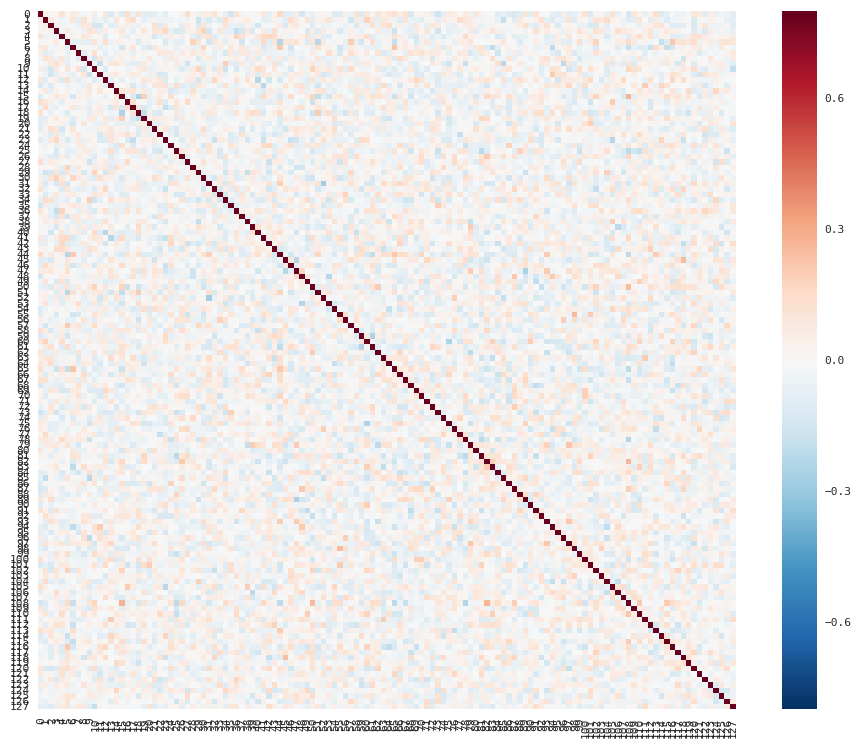

In [4]:
sns.set(context="paper", font="monospace")
corrmat = X_test.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Visiblement, aucune corrélation évidente n'apparait.
On va se donner une référence avec un modèle de base.

In [5]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# Prediction
y_pred_train =  clf.predict(X_train)

# Compute the score
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 0.6387310606060606


On va maintenant étudier les différentes *features*

In [7]:
estimator = linear_model.LogisticRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train, y_train)

In [8]:
print(selector.support_) 
print(selector.ranking_)

[False  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True]
[ 9  1  1  1  1  1  1  1  1  1  8  1  1  1  1  1  1  4  7  1  1  1  1  1  1
  1  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

In [9]:
print(np.where(selector.support_ == False))

(array([  0,  10,  17,  18,  28,  72,  80, 104, 117]),)


D'aprés cette sélection on voit que les colonnes #0, #10, #17, #18, #28, #72, #80, #104 et #117 ne sont pas significatives pour la régression logistique

In [10]:
X_test.drop([  0,  10,  17,  18,  28,  72,  80, 104, 117], axis=1, inplace= True)
X_train.drop([  0,  10,  17,  18,  28,  72,  80, 104, 117],axis=1, inplace= True)

In [11]:
print(X_test.shape, X_train.shape)

(8496, 119) (105600, 119)


Est-ce que le retrait de ces colonnes améliore le score ?

In [12]:
clf.fit(X_train, y_train)
# Prediction
y_pred_train =  clf.predict(X_train)

# Compute the score
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 0.6385416666666667


Il y'a une légère amélioration du score.
Prennons ce classifieur comme notre base de référence.
Sur le leaderboard le score n'est pas interessant.
La classification concerne le traitement d'image, nous savons que sur ce type de problématique, les réseaux de neurones sont performants. Nous allons dorénavant exploiter la classe MLP de sklearn et faire notre sélection de variables en ce sens.

In [13]:
clf2 = MLPClassifier()
clf2.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [14]:
# Prediction
y_pred_train =  clf2.predict(X_train)

# Compute the score
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 0.0002840909090909091


Le score est déjà plus intéressant

In [15]:
y_pred = clf2.predict(X_test)
np.savetxt('y_pred.txt', y_pred, fmt='%d')

Sur le leaderboard nous obtenons un score de **0.35**
Est-ce que la standardization améliore le score ?

In [16]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [17]:
# Prediction
y_pred_train =  clf2.predict(X_train)

# Compute the score
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 0.07831439393939393


Sur les données d'entrainement le score se dégrade.

In [18]:
y_pred = clf2.predict(X_test)
np.savetxt('y_pred.txt', y_pred, fmt='%d')

La même dégradation se constate sur le leaderboard avec un score de **0.40**

Maintenant nous allons rechercher les hyper paramètres optimaux via un grid search

In [19]:
# Rechargeons nos données sans Standardization
X_train = pd.DataFrame(pd.read_csv(X_train_fname, sep=',', header=None))
X_test  = pd.DataFrame(pd.read_csv(X_test_fname,  sep=',', header=None).values)
X_test.drop([  0,  10,  17,  18,  28,  72,  80, 104, 117], axis=1, inplace= True)
X_train.drop([  0,  10,  17,  18,  28,  72,  80, 104, 117],axis=1, inplace= True)

In [ ]:
clf2 = MLPClassifier(max_iter=50, solver='adam')
param_grid = { 'activation' : ['identity', 'logistic', 'tanh', 'relu'],
              'alpha': np.arange(0.0001,0.001, 0.0001), 'hidden_layer_sizes':range(1,5)}
grid_search = GridSearchCV(clf2, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(grid_search.cv_results_)

Maintenant que l'on a optimisé les hyper-paramètres on va prédire sur les données de test.
Lorsque on se trouve trop proche de la frontière de décision on ne va pas se prononcer et prédire 0.